In [271]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from tensorflow import keras
from keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Dense,Dropout, BatchNormalization
import keras_cv
import cv2
import shutil
from ultralytics import YOLO

In [2]:
df_bounding_box_labels = pd.read_csv(r'data\Human_Face_Detection_Dataset\faces.csv')

In [3]:
display(df_bounding_box_labels)

,image_name,width,height,x0,y0,x1,y1
0,00001722.jpg,1333,2000,490,320,687,664
1,00001044.jpg,2000,1333,791,119,1200,436
2,00001050.jpg,667,1000,304,155,407,331
3,00001736.jpg,626,417,147,14,519,303
4,00003121.jpg,626,418,462,60,599,166
...,...,...,...,...,...,...,...
3345,00002232.jpg,620,349,4,36,186,158
3346,00002232.jpg,620,349,122,103,344,248
3347,00002232.jpg,620,349,258,118,541,303
3348,00002232.jpg,620,349,215,11,362,108


In [4]:
sorted_df = df_bounding_box_labels.sort_values(by='image_name', ascending=True)

In [5]:
images_folder = "data\Human_Face_Detection_Dataset\images"

image_file_paths = sorted(
    [os.path.join(images_folder, fname)
     for fname in os.listdir(images_folder)
     if fname.endswith(".jpg")])

In [6]:
print(f"{len(image_file_paths)} image file paths found.")
print("First 5 file paths:\n", "\n".join(image_file_paths[:5]))

2204 image file paths found.
First 5 file paths:
 data\Human_Face_Detection_Dataset\images\00000003.jpg
data\Human_Face_Detection_Dataset\images\00000004.jpg
data\Human_Face_Detection_Dataset\images\00000005.jpg
data\Human_Face_Detection_Dataset\images\00000006.jpg
data\Human_Face_Detection_Dataset\images\00000008.jpg


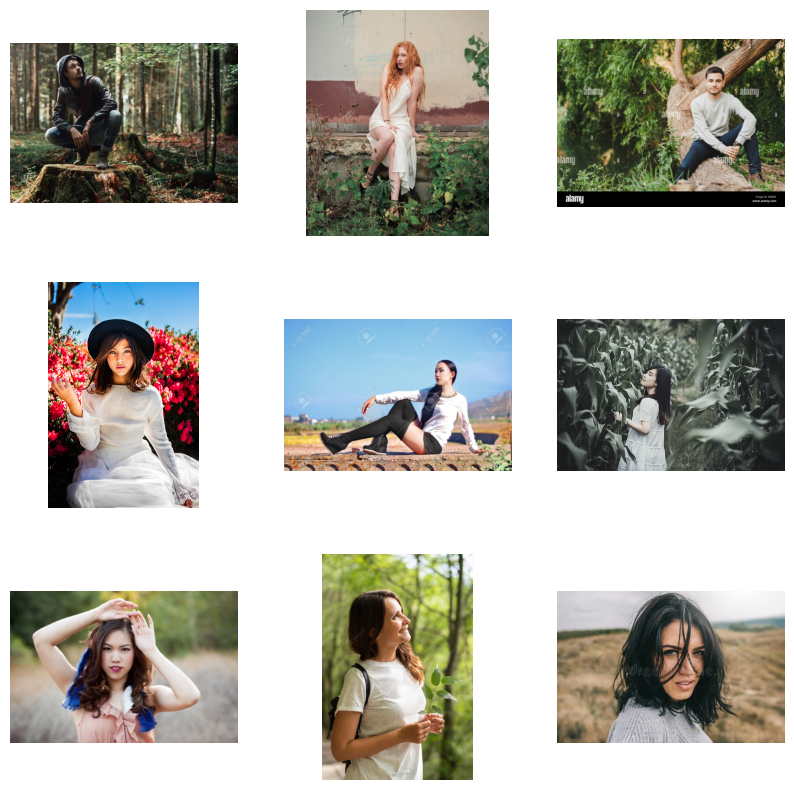

In [7]:
# present the first 9 images in a 3x3 grid.
plt.figure(figsize=(10, 10))
for i, image_file_path in enumerate(image_file_paths[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(load_img(image_file_path))
    plt.axis("off")

In [8]:
data = {}
for index, row in sorted_df.iterrows():
    img_name = row['image_name']
    if img_name not in data:
        data[img_name] = []
    data[img_name].append((row['x0'], row['y0'], row['x1'], row['y1']))

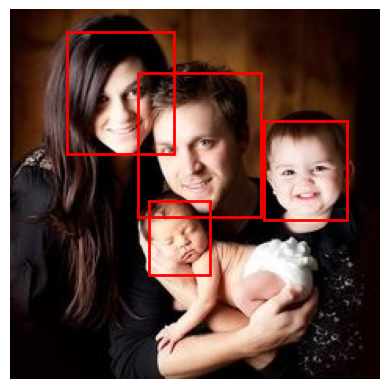

In [9]:
def plot_image_with_boxes(image_path, bounding_boxes):
    img = load_img(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    for bbox in bounding_boxes:
        x0, y0, x1, y1 = bbox
        # Create a rectangle patch
        rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none')
        # Add the rectangle to the plot
        ax.add_patch(rect)
    plt.axis("off")
    plt.show()

# Example usage
image_path = image_file_paths[2203]  # Change this to the path of your image
image_name = os.path.basename(image_path)
bounding_boxes = data[image_name]
plot_image_with_boxes(image_path, bounding_boxes)

In [10]:
new_bbox_after_resize = {}
for index, row in sorted_df.iterrows():
    img_name = row['image_name']
    width = row["width"]
    height = row["height"]
    width_ratio = 224/width
    height_ratio = 224/height
    if img_name not in new_bbox_after_resize:
        new_bbox_after_resize[img_name] = []
    new_bbox_after_resize[img_name].append((int(row['x0']*width_ratio), int(row['y0']*height_ratio), int(row['x1']*width_ratio), int(row['y1']*height_ratio)))

In [11]:
target_size = (224, 224)
resized_images = []

In [12]:
def plot_image_after_resize(image_path,target_size):
    img = load_img(image_path,target_size=target_size)
    image_name = os.path.basename(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    bounding_boxes = new_bbox_after_resize[image_name]
    for bbox in bounding_boxes:
        x0, y0, x1, y1 = bbox
        # Create a rectangle patch
        rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none')
        # Add the rectangle to the plot
        ax.add_patch(rect)
    plt.axis("off")
    plt.show()
    

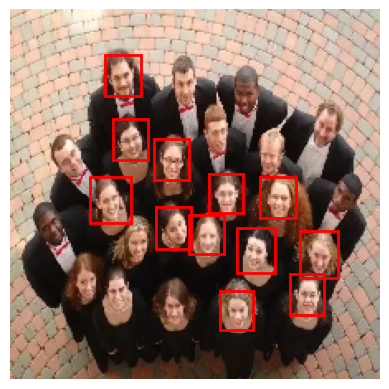

In [13]:
plot_image_after_resize(image_file_paths[295],target_size)

In [14]:
for image_path in image_file_paths:
    img = load_img(image_path,target_size=target_size)
    img_array = img_to_array(img)
    resized_images.append(img_array)

In [15]:
resized_images_arr = np.array(resized_images)

In [16]:
resized_images_arr.shape

(2204, 224, 224, 3)

In [17]:
rescaled_images = resized_images_arr.astype('float32') / 255.0

In [18]:
bounding_boxes = []

In [19]:
for img_name, bboxes in new_bbox_after_resize.items():
    coord = []
    for bbox in bboxes:
        for cord in bbox:
            coord.append(cord)
    bounding_boxes.append(coord)

In [20]:
max_bbox = 0
for i in range(len(bounding_boxes)):
    max_bbox = max(max_bbox, len(bounding_boxes[i]))

In [21]:
for i in range(len(bounding_boxes)):
    if int(max_bbox) - len(bounding_boxes[i]) != 0:
        for j in range(int(max_bbox) - len(bounding_boxes[i])):
            bounding_boxes[i].append(0)

In [22]:
bbox = np.array(bounding_boxes)

In [23]:
bbox.shape

(2204, 48)

In [24]:
X_train, X_temp, y_train, y_temp = train_test_split(rescaled_images, bbox, test_size = 0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 42)

In [25]:
X_val.shape

(220, 224, 224, 3)

In [41]:
CNN_model = Sequential([
    Conv2D(32, 3, input_shape = (224,224,3), activation = 'relu'),
    Dropout(0.1),
    MaxPool2D(pool_size = 2),
    BatchNormalization(),
    Conv2D(64, 3, activation = 'relu'),
    Dropout(0.2),
    MaxPool2D(pool_size = 2),
    BatchNormalization(),
    Conv2D(128, 3, activation = 'relu'),
    Dropout(0.3),
    MaxPool2D(pool_size = 2),
    BatchNormalization(),
    Conv2D(256, 3, activation = 'relu'),
    Dropout(0.4),
    MaxPool2D(pool_size = 2),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(256, activation = 'relu'),
    Dense(48) #output layer
])

In [42]:
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 dropout (Dropout)           (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 111, 111, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 dropout_1 (Dropout)         (None, 109, 109, 64)      0

In [43]:
CNN_model.compile(loss="mse",
              optimizer="adam",
              metrics=["accuracy"])

In [44]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/CNN_Face_Detection.keras",
        save_best_only=True,
        monitor="val_loss")
]

In [121]:
history = CNN_model.fit(X_train,y_train,epochs=50,batch_size=64,validation_data=(X_val,y_val),callbacks=callbacks)

Epoch 1/50
28/28 [==============================] - 110s 4s/step - loss: 1339.3672 - accuracy: 0.7215 - val_loss: 1549.5322 - val_accuracy: 0.7409
Epoch 2/50
28/28 [==============================] - 101s 4s/step - loss: 983.2216 - accuracy: 0.7618 - val_loss: 1366.1924 - val_accuracy: 0.7409
Epoch 3/50
28/28 [==============================] - 100s 4s/step - loss: 719.5601 - accuracy: 0.7618 - val_loss: 1096.2998 - val_accuracy: 0.7409
Epoch 4/50
28/28 [==============================] - 105s 4s/step - loss: 627.1389 - accuracy: 0.7618 - val_loss: 922.0137 - val_accuracy: 0.7409
Epoch 5/50
28/28 [==============================] - 104s 4s/step - loss: 601.8512 - accuracy: 0.7612 - val_loss: 881.9556 - val_accuracy: 0.7409
Epoch 6/50
28/28 [==============================] - 104s 4s/step - loss: 537.3743 - accuracy: 0.7618 - val_loss: 824.8350 - val_accuracy: 0.7409
Epoch 7/50
28/28 [==============================] - 100s 4s/step - loss: 497.6294 - accuracy: 0.7618 - val_loss: 822.7520 - va

In [48]:
CNN_test_model = keras.models.load_model(
    "./models/CNN_Face_Detection.keras")

In [85]:
# Define a function to plot images with bounding boxes
def plot_images_with_boxes(images, boxes):
    num_images = len(images)
    num_cols = 2  # Original image + Image with bounding boxes
    num_rows = 2
    
    plt.figure(figsize=(7, 5))
    
    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(images[i])
        
        for box in boxes[i].reshape(12,4):
            x_min, y_min, x_max, y_max = box
            plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none'))
        
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [197]:
def calculate_MeanIOU(predicted_bbox,ground_truth_bbox):
    mean_iou_scores = np.zeros(predicted_bbox.shape[0])
    for i in range(predicted_bbox.shape[0]):
        valid_ground_truth_boxes = ground_truth_bbox[i][np.any(ground_truth_bbox[i] != 0, axis=1)]
        valid_predicted_boxes = predicted_bbox[i][:len(valid_ground_truth_boxes)]
        iou_score = keras_cv.bounding_box.compute_iou( boxes1=valid_predicted_boxes, boxes2=valid_ground_truth_boxes, bounding_box_format='xyxy',use_masking=True,mask_val = 0).numpy()
        mean_iou = np.mean(iou_score)
        mean_iou_scores[i] = mean_iou
    return np.mean(mean_iou_scores)


In [195]:
train_bounding_boxes = CNN_test_model.predict(X_train)

56/56 [==============================] - 14s 240ms/step


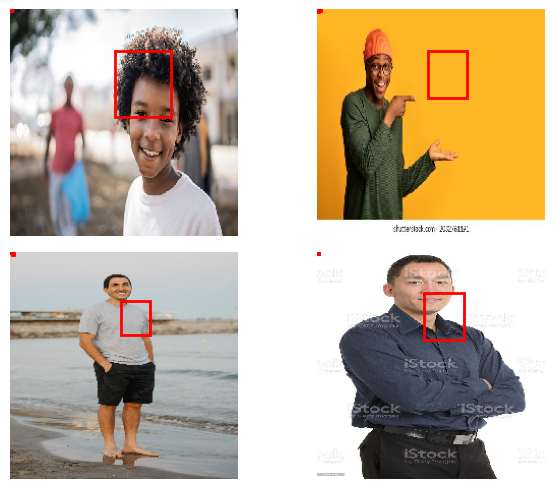

In [196]:
train_predicted_bounding_boxes= np.round(train_bounding_boxes).astype(int)

num_samples =  4  # Plot up to 5 images
plot_images_with_boxes(X_train[:num_samples], train_predicted_bounding_boxes[:num_samples])

In [199]:
predicted_train_box_reshaped = train_predicted_bounding_boxes.reshape(X_train.shape[0],12,4)
train_ground_truth =y_train.reshape(y_train.shape[0],12,4)

In [201]:
print("Mean Intersection Over Union for Training dataset ",calculate_MeanIOU(predicted_train_box_reshaped,train_ground_truth))

Mean Intersection Over Union for Training dataset  0.16198702135663426


In [194]:
Val_bounding_boxes = CNN_test_model.predict(X_val)

7/7 [==============================] - 2s 284ms/step


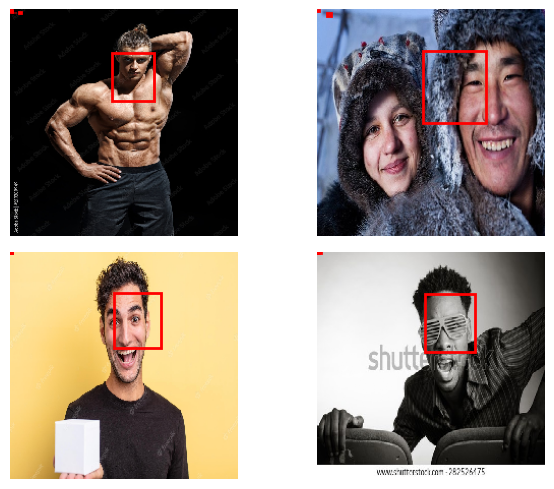

In [86]:
val_predicted_bounding_boxes= np.round(Val_bounding_boxes).astype(int)

num_samples =  4  # Plot up to 5 images
plot_images_with_boxes(X_val[:num_samples], val_predicted_bounding_boxes[:num_samples])

In [89]:
predicted_val_box_reshaped = val_predicted_bounding_boxes.reshape(220,12,4)
val_ground_truth =y_val.reshape(220,12,4)

In [192]:
print("Mean Intersection Over Union for Validation dataset ",calculate_MeanIOU(predicted_val_box_reshaped,val_ground_truth))

Mean Intersection Over Union for Validation dataset  0.150789400686203


In [182]:
test_bounding_boxes = CNN_test_model.predict(X_test)

7/7 [==============================] - 2s 293ms/step


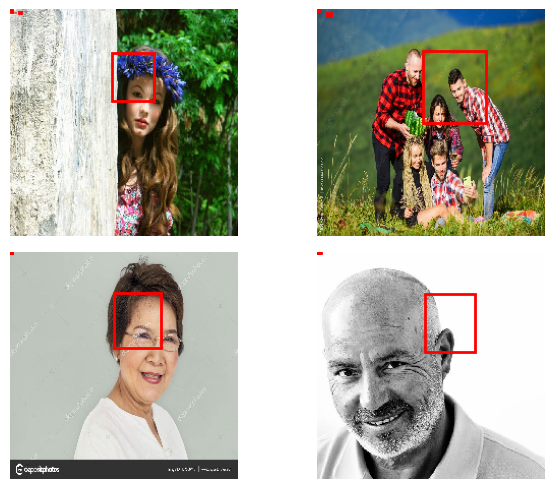

In [183]:
test_predicted_bounding_boxes= np.round(test_bounding_boxes).astype(int)

num_samples =  4  # Plot up to 5 images
plot_images_with_boxes(X_test[:num_samples], val_predicted_bounding_boxes[:num_samples])

In [185]:
predicted_test_box_reshaped = test_predicted_bounding_boxes.reshape(X_test.shape[0],12,4)
test_ground_truth =y_test.reshape(y_test.shape[0],12,4)

In [193]:
print("Mean Intersection Over Union for Testing dataset ",calculate_MeanIOU(predicted_test_box_reshaped,test_ground_truth))

Mean Intersection Over Union for Testing dataset  0.15025931122350375


In [ ]:
rescaled_images

In [227]:
face_list=os.listdir(images_folder)

In [230]:
imgtrain_list=face_list[:int(len(face_list)*0.8)]
imgval_list=face_list[int(len(face_list)*0.8):int(len(face_list)*(0.8+0.1))]
imgtest_list=face_list[int(len(face_list)*(0.8+0.1)):]

In [237]:
def change_extension(file):
    basename=os.path.splitext(file)[0]
    filename=basename+'.txt'
    return filename

In [238]:
labeltrain_list = list(map(change_extension, imgtrain_list)) 
labelval_list = list(map(change_extension, imgval_list)) 
labeltest_list = list(map(change_extension, imgtest_list)) 

In [229]:
sorted_df['x_centre']=0.5*(sorted_df['x0']+sorted_df['x1'])
sorted_df['y_centre']=0.5*(sorted_df['y0']+sorted_df['y1'])
sorted_df['bb_width']=sorted_df['x1']-sorted_df['x0']
sorted_df['bb_height']=sorted_df['y1']-sorted_df['y0']
sorted_df

,image_name,width,height,x0,y0,x1,y1,x_centre,y_centre,bb_width,bb_height
586,00000003.jpg,500,350,101,25,176,87,138.5,56.0,75,62
87,00000004.jpg,1000,1241,476,177,588,335,532.0,256.0,112,158
173,00000005.jpg,1300,957,811,171,976,313,893.5,242.0,165,142
396,00000006.jpg,2667,4000,1002,787,1547,1739,1274.5,1263.0,545,952
3167,00000008.jpg,1300,867,820,234,1016,387,918.0,310.5,196,153
...,...,...,...,...,...,...,...,...,...,...,...
3278,00003514.jpg,236,354,93,37,133,106,113.0,71.5,40,69
3063,00003517.jpg,236,236,81,40,160,132,120.5,86.0,79,92
3064,00003517.jpg,236,236,162,71,215,134,188.5,102.5,53,63
3065,00003517.jpg,236,236,36,14,104,92,70.0,53.0,68,78


In [236]:
sorted_df['xcentre_scaled']=sorted_df['x_centre']/sorted_df['width']
sorted_df['ycentre_scaled']=sorted_df['y_centre']/sorted_df['height']
sorted_df['width_scaled']=sorted_df['bb_width']/sorted_df['width']
sorted_df['height_scaled']=sorted_df['bb_height']/sorted_df['height']
sorted_df

,image_name,width,height,x0,y0,x1,y1,x_centre,y_centre,bb_width,bb_height,xcentre_scaled,ycentre_scaled,width_scaled,height_scaled
586,00000003.jpg,500,350,101,25,176,87,138.5,56.0,75,62,0.277000,0.160000,0.150000,0.177143
87,00000004.jpg,1000,1241,476,177,588,335,532.0,256.0,112,158,0.532000,0.206285,0.112000,0.127317
173,00000005.jpg,1300,957,811,171,976,313,893.5,242.0,165,142,0.687308,0.252874,0.126923,0.148380
396,00000006.jpg,2667,4000,1002,787,1547,1739,1274.5,1263.0,545,952,0.477878,0.315750,0.204349,0.238000
3167,00000008.jpg,1300,867,820,234,1016,387,918.0,310.5,196,153,0.706154,0.358131,0.150769,0.176471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3278,00003514.jpg,236,354,93,37,133,106,113.0,71.5,40,69,0.478814,0.201977,0.169492,0.194915
3063,00003517.jpg,236,236,81,40,160,132,120.5,86.0,79,92,0.510593,0.364407,0.334746,0.389831
3064,00003517.jpg,236,236,162,71,215,134,188.5,102.5,53,63,0.798729,0.434322,0.224576,0.266949
3065,00003517.jpg,236,236,36,14,104,92,70.0,53.0,68,78,0.296610,0.224576,0.288136,0.330508


In [239]:
imgs=sorted_df.groupby('image_name') 

In [240]:
curr_path=os.getcwd()
imgtrainpath = os.path.join(curr_path,'images','train')
imgvalpath=os.path.join(curr_path,'images','validation')
imgtestpath=os.path.join(curr_path,'images','test')

labeltrainpath=os.path.join(curr_path,'labels','train')
labelvalpath=os.path.join(curr_path,'labels','validation')
labeltestpath=os.path.join(curr_path,'labels','test')

In [241]:
labels_path = os.path.join(curr_path, 'face_labels')

In [243]:
os.makedirs(labels_path)

In [256]:
data_path= 'data\Human_Face_Detection_Dataset'

In [244]:
for image in imgs:
    img_df=imgs.get_group(image[0])
    basename=os.path.splitext(image[0])[0]
    txt_file=basename+'.txt'
    filepath=os.path.join(labels_path, txt_file)
    lines=[]
    i=1
    for index,row in img_df.iterrows():
        if i!=len(img_df):
            line=str(0)+' '+str(row['xcentre_scaled'])+' '+str(row['ycentre_scaled'])+' '+str(row['width_scaled'])+' '+str(row['height_scaled'])+'\n'
            lines.append(line)
        else:
            line=str(0)+' '+str(row['xcentre_scaled'])+' '+str(row['ycentre_scaled'])+' '+str(row['width_scaled'])+' '+ str(row['height_scaled'])
            lines.append(line)
        i=i+1
    with open(filepath, 'w') as file:
        file.writelines(lines)

In [263]:
def move_files(data_list, source_path, destination_path):
    i=0
    for file in data_list:
        filepath=os.path.join(source_path, file)
        dest_path=os.path.join(data_path, destination_path)
        if not os.path.isdir(dest_path):
            os.makedirs(dest_path)
        shutil.move(filepath, dest_path)
        i=i+1
    print("Number of files transferred:", i)

In [254]:
def move_images(data_list, source_path, destination_path):
    i=0
    for file in data_list:
        filepath=os.path.join(source_path, file)
        dest_path=os.path.join(data_path, destination_path)
        
        if not os.path.isdir(dest_path):
            os.makedirs(dest_path)
        finalimage_path=os.path.join(dest_path, file)
        print(filepath)
        img_resized=cv2.resize(cv2.imread(filepath), (640, 640))
        cv2.imwrite(finalimage_path, img_resized)
        i=i+1
    print("Number of files transferred:", i)

In [257]:
img_path=os.path.join(data_path, 'images')

In [258]:
move_images(imgtrain_list, img_path, imgtrainpath)

data\Human_Face_Detection_Dataset\images\00000003.jpg
data\Human_Face_Detection_Dataset\images\00000004.jpg
data\Human_Face_Detection_Dataset\images\00000005.jpg
data\Human_Face_Detection_Dataset\images\00000006.jpg
data\Human_Face_Detection_Dataset\images\00000008.jpg
data\Human_Face_Detection_Dataset\images\00000011.jpg
data\Human_Face_Detection_Dataset\images\00000012.jpg
data\Human_Face_Detection_Dataset\images\00000015.jpg
data\Human_Face_Detection_Dataset\images\00000018.jpg
data\Human_Face_Detection_Dataset\images\00000020.jpg
data\Human_Face_Detection_Dataset\images\00000022.jpg
data\Human_Face_Detection_Dataset\images\00000023.jpg
data\Human_Face_Detection_Dataset\images\00000024.jpg
data\Human_Face_Detection_Dataset\images\00000026.jpg
data\Human_Face_Detection_Dataset\images\00000031.jpg
data\Human_Face_Detection_Dataset\images\00000032.jpg
data\Human_Face_Detection_Dataset\images\00000041.jpg
data\Human_Face_Detection_Dataset\images\00000044.jpg
data\Human_Face_Detection_Da

In [259]:
move_images(imgval_list, img_path, imgvalpath)

data\Human_Face_Detection_Dataset\images\00002830.jpg
data\Human_Face_Detection_Dataset\images\00002836.jpg
data\Human_Face_Detection_Dataset\images\00002837.jpg
data\Human_Face_Detection_Dataset\images\00002839.jpg
data\Human_Face_Detection_Dataset\images\00002841.jpg
data\Human_Face_Detection_Dataset\images\00002842.jpg
data\Human_Face_Detection_Dataset\images\00002843.jpg
data\Human_Face_Detection_Dataset\images\00002845.jpg
data\Human_Face_Detection_Dataset\images\00002846.jpg
data\Human_Face_Detection_Dataset\images\00002847.jpg
data\Human_Face_Detection_Dataset\images\00002848.jpg
data\Human_Face_Detection_Dataset\images\00002850.jpg
data\Human_Face_Detection_Dataset\images\00002851.jpg
data\Human_Face_Detection_Dataset\images\00002852.jpg
data\Human_Face_Detection_Dataset\images\00002853.jpg
data\Human_Face_Detection_Dataset\images\00002854.jpg
data\Human_Face_Detection_Dataset\images\00002855.jpg
data\Human_Face_Detection_Dataset\images\00002856.jpg
data\Human_Face_Detection_Da

In [260]:
move_images(imgtest_list, img_path, imgtestpath)

data\Human_Face_Detection_Dataset\images\00003160.jpg
data\Human_Face_Detection_Dataset\images\00003161.jpg
data\Human_Face_Detection_Dataset\images\00003162.jpg
data\Human_Face_Detection_Dataset\images\00003163.jpg
data\Human_Face_Detection_Dataset\images\00003165.jpg
data\Human_Face_Detection_Dataset\images\00003166.jpg
data\Human_Face_Detection_Dataset\images\00003167.jpg
data\Human_Face_Detection_Dataset\images\00003168.jpg
data\Human_Face_Detection_Dataset\images\00003169.jpg
data\Human_Face_Detection_Dataset\images\00003171.jpg
data\Human_Face_Detection_Dataset\images\00003172.jpg
data\Human_Face_Detection_Dataset\images\00003173.jpg
data\Human_Face_Detection_Dataset\images\00003175.jpg
data\Human_Face_Detection_Dataset\images\00003177.jpg
data\Human_Face_Detection_Dataset\images\00003178.jpg
data\Human_Face_Detection_Dataset\images\00003183.jpg
data\Human_Face_Detection_Dataset\images\00003184.jpg
data\Human_Face_Detection_Dataset\images\00003185.jpg
data\Human_Face_Detection_Da

In [264]:
move_files(labeltrain_list, labels_path, labeltrainpath)

Number of files transferred: 1763


In [265]:
move_files(labelval_list, labels_path, labelvalpath)

Number of files transferred: 220


In [266]:
move_files(labeltest_list, labels_path, labeltestpath)

Number of files transferred: 221


In [267]:
ln_1='# Train/val/test sets'+'\n'
ln_2='train: ' +"'"+imgtrainpath+"'"+'\n'
ln_3='val: ' +"'" + imgvalpath+"'"+'\n'
ln_4='test: ' +"'" + imgtestpath+"'"+'\n'
ln_5='\n'
ln_6='# Classes'+'\n'
ln_7='names:'+'\n'
ln_8='  0: face'
config_lines=[ln_1, ln_2, ln_3, ln_4, ln_5, ln_6, ln_7, ln_8]

In [268]:
config_path=os.path.join(curr_path, 'config.yaml')
config_path

'c:\\Users\\hemas\\Documents\\Applied_AI_and_ML_Courses\\Foundations_Of_ML\\labs\\Human-Face-detection\\config.yaml'

In [269]:
with open(config_path, 'w') as f:
    f.writelines(config_lines)

In [307]:
model=YOLO('yolov8n.pt')

In [308]:
model.info()

YOLOv8n summary: 225 layers, 3157200 parameters, 0 gradients, 8.9 GFLOPs


(225, 3157200, 0, 8.8575488)

In [310]:
results=model.train(data=config_path,imgsz=640,epochs=10,patience=20,optimizer='Adam',lr0=0.001,lrf=0.01,device='cpu')

Ultralytics YOLOv8.1.47  Python-3.11.7 torch-2.2.2+cpu CPU (AMD Ryzen 7 5800HS with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=c:\Users\hemas\Documents\Applied_AI_and_ML_Courses\Foundations_Of_ML\labs\Human-Face-detection\config.yaml, epochs=10, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=Fal

train: Scanning C:\Users\hemas\Documents\Applied_AI_and_ML_Courses\Foundations_Of_ML\labs\Human-Face-detection\data\YOLO_Format\labels\train.cache... 1763 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1763/1763 [00:00<?, ?it/s]
val: Scanning C:\Users\hemas\Documents\Applied_AI_and_ML_Courses\Foundations_Of_ML\labs\Human-Face-detection\data\YOLO_Format\labels\validation.cache... 220 images, 0 backgrounds, 0 corrupt: 100%|██████████| 220/220 [00:00<?, ?it/s]

Plotting labels to c:\Users\hemas\Documents\Applied_AI_and_ML_Courses\Foundations_Of_ML\labs\CSCN8010\runs\detect\train5\labels.jpg... 


optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to c:\Users\hemas\Documents\Applied_AI_and_ML_Courses\Foundations_Of_ML\labs\CSCN8010\runs\detect\train5
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.418      1.401      1.532         11        640: 100%|██████████| 111/111 [09:17<00:00,  5.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:26<00:00,  3.79s/it]

                   all        220        411       0.72      0.698      0.715      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.211     0.8987      1.354          3        640: 100%|██████████| 111/111 [08:47<00:00,  4.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:25<00:00,  3.65s/it]

                   all        220        411       0.81      0.789      0.862      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      1.149     0.7636      1.334          3        640: 100%|██████████| 111/111 [1:01:19<00:00, 33.15s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:27<00:00,  3.98s/it]

                   all        220        411      0.778        0.9      0.825      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.084     0.7089      1.271          6        640: 100%|██████████| 111/111 [09:50<00:00,  5.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:31<00:00,  4.43s/it]

                   all        220        411       0.82      0.878      0.918       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.038     0.6607      1.249          3        640: 100%|██████████| 111/111 [10:44<00:00,  5.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:31<00:00,  4.57s/it]

                   all        220        411       0.83      0.929      0.925      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G     0.9795     0.5966       1.19          3        640: 100%|██████████| 111/111 [09:15<00:00,  5.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:25<00:00,  3.68s/it]

                   all        220        411       0.81      0.953      0.934       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G     0.9133     0.5672      1.159          3        640: 100%|██████████| 111/111 [08:53<00:00,  4.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:25<00:00,  3.62s/it]

                   all        220        411      0.892      0.903      0.937      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G     0.8562     0.5321      1.121          4        640: 100%|██████████| 111/111 [08:27<00:00,  4.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:26<00:00,  3.72s/it]

                   all        220        411      0.891      0.937      0.957      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G     0.8158      0.499      1.095          3        640: 100%|██████████| 111/111 [08:34<00:00,  4.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:23<00:00,  3.41s/it]

                   all        220        411      0.876      0.937      0.953      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G     0.7864     0.4724      1.076          4        640: 100%|██████████| 111/111 [08:05<00:00,  4.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:23<00:00,  3.41s/it]

                   all        220        411      0.876      0.925      0.951      0.743



10 epochs completed in 2.464 hours.
Optimizer stripped from c:\Users\hemas\Documents\Applied_AI_and_ML_Courses\Foundations_Of_ML\labs\CSCN8010\runs\detect\train5\weights\last.pt, 6.2MB
Optimizer stripped from c:\Users\hemas\Documents\Applied_AI_and_ML_Courses\Foundations_Of_ML\labs\CSCN8010\runs\detect\train5\weights\best.pt, 6.2MB

Validating c:\Users\hemas\Documents\Applied_AI_and_ML_Courses\Foundations_Of_ML\labs\CSCN8010\runs\detect\train5\weights\best.pt...
Ultralytics YOLOv8.1.47  Python-3.11.7 torch-2.2.2+cpu CPU (AMD Ryzen 7 5800HS with Radeon Graphics)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:20<00:00,  2.96s/it]


                   all        220        411      0.878      0.926      0.951      0.743
Speed: 2.7ms preprocess, 85.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to c:\Users\hemas\Documents\Applied_AI_and_ML_Courses\Foundations_Of_ML\labs\CSCN8010\runs\detect\train5


In [311]:
model.save('models\custom_trained_yolov8.pt')

In [313]:
fine_tuned_model = YOLO('models\custom_trained_yolov8.pt')